In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna.samplers import TPESampler

import lightgbm as lgb
import xgboost as xgb

from sklearn.pipeline import Pipeline

from src.model_validation import TSCrossValidate, summary_evaluation, fold_evaluation
from src.model_helpers import DailyModel
from src.sharpe import score_sharpe

import warnings
warnings.filterwarnings("ignore")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv("data_raw/train.csv")
df.head()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [3]:
def create_features(data):
    df = data.copy()
    
    # Targets to create lags from
    targets = ['forward_returns', 'risk_free_rate']
    
    # 1. Lags (Past Memory)
    for col in targets:
        for lag in [1, 2, 3, 5, 10]:
            df[f'lag_{col}_{lag}'] = df[col].shift(lag)
            
    # 2. Volatility Features (Risk Detection)
    # Using lagged returns to measure recent risk
    base_col = 'lag_forward_returns_1'
    
    # Short & Long term Volatility
    df['vol_5d'] = df[base_col].rolling(5).std()
    df['vol_22d'] = df[base_col].rolling(22).std() # Monthly Vol
    
    # 3. Momentum (Trend Strength)
    df['mom_5d'] = df[base_col].rolling(5).mean()
    df['mom_22d'] = df[base_col].rolling(22).mean()
    
    # Z-Score (Is price unusual?)
    df['zscore_22'] = (df[base_col] - df['mom_22d']) / (df['vol_22d'] + 1e-8)
    
    # 4. Fill NaNs
    # df = df.fillna(0)
    return df

In [4]:
train = create_features(df)

In [5]:
TARGET = "market_forward_excess_returns"
DROP = ['is_scored', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
FEATURES = [c for c in train.columns if c not in DROP]

In [6]:
ts_folds = TimeSeriesSplit(n_splits=10, test_size=180)

In [7]:
processing = Pipeline([("imputer", tml.DfImputer(strategy="constant", fill_value=0)), ("scaler", tml.DfScaler())])

# Linear Model

In [ ]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "alpha": trial.suggest_float("alpha", 1, 100),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.1, 1),
        "create_features": trial.suggest_categorical("create_features", [True, False]),
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "conversion": trial.suggest_int("conversion", 1, 1000)
    }
    processing = Pipeline([("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                           ("scaler", tml.DfScaler())])
    if param["create_features"]:
        train = create_features(data)
    else:
        train = data

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = ElasticNet(alpha=param["alpha"], l1_ratio=param["l1_ratio"], random_state=325)

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id"}
    else:
        fit_params = {}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"] * param["conversion"] + 1, 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [9]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2025-11-30 13:21:12,499] A new study created in memory with name: no-name-f46fe40f-0ee4-4d93-bfd5-f595589c1f65


Number of finished trials: 200
Best trial: {'alpha': 14.082662143805145, 'l1_ratio': 0.39134987963544576, 'create_features': False, 'strategy': 'constant', 'sample_weight': False, 'conversion': 1}


In [10]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_conversion,params_create_features,params_l1_ratio,params_sample_weight,params_strategy,state
94,94,0.640614,2025-11-30 13:22:21.043564,2025-11-30 13:22:38.522906,0 days 00:00:17.479342,13.342515,1,True,0.387469,False,constant,COMPLETE
185,185,0.640614,2025-11-30 13:23:45.740366,2025-11-30 13:23:59.349129,0 days 00:00:13.608763,12.210533,1,True,0.389147,False,constant,COMPLETE
103,103,0.640614,2025-11-30 13:22:31.254413,2025-11-30 13:22:45.678655,0 days 00:00:14.424242,14.717801,1,True,0.380735,False,constant,COMPLETE
107,107,0.640614,2025-11-30 13:22:34.075193,2025-11-30 13:22:47.654862,0 days 00:00:13.579669,14.614887,1,True,0.398000,False,median,COMPLETE
108,108,0.640614,2025-11-30 13:22:35.831153,2025-11-30 13:22:50.293260,0 days 00:00:14.462107,14.016164,1,True,0.344947,False,median,COMPLETE
110,110,0.640614,2025-11-30 13:22:38.321643,2025-11-30 13:22:53.221519,0 days 00:00:14.899876,13.356765,1,True,0.888989,False,median,COMPLETE
170,170,0.640614,2025-11-30 13:23:32.830968,2025-11-30 13:23:46.127192,0 days 00:00:13.296224,12.006082,1,True,0.313507,False,constant,COMPLETE
174,174,0.640614,2025-11-30 13:23:39.095132,2025-11-30 13:23:53.648829,0 days 00:00:14.553697,11.666308,1,True,0.322128,False,constant,COMPLETE
173,173,0.640614,2025-11-30 13:23:36.584039,2025-11-30 13:23:48.537174,0 days 00:00:11.953135,12.006456,1,True,0.319488,False,constant,COMPLETE
172,172,0.640614,2025-11-30 13:23:34.766342,2025-11-30 13:23:48.500454,0 days 00:00:13.734112,12.074626,1,True,0.384345,False,constant,COMPLETE


In [11]:
optuna.visualization.plot_optimization_history(study)

In [12]:
optuna.visualization.plot_param_importances(study)

In [13]:
optuna.visualization.plot_contour(study, params=['conversion', 'alpha', 'l1_ratio'])

Mean Squared Error: 0.00012
R2: -0.0002802998318685024
MAE: 0.007926483420219316
               min      mean       max
fold                                  
0     1.128986e-09  0.000110  0.001546
1     3.756913e-10  0.000061  0.000928
2     2.868247e-09  0.000322  0.001625
3     6.450893e-10  0.000079  0.001192
4     4.656548e-10  0.000103  0.000891
5     4.027684e-10  0.000246  0.001643
6     1.918253e-09  0.000078  0.000624
7     6.923932e-12  0.000054  0.000406
8     6.187906e-10  0.000069  0.000920
9     5.237794e-10  0.000117  0.001651
Sharpe: 0.6406138329391244
0 -0.223030977633935
1 1.6085672096963926
2 0.6296779306039075
3 2.478625781847355
4 0.41391984750396926
5 -0.8081853233853052
6 0.9798122875098716
7 1.6283334390047337
8 1.0719220611164577
9 0.614819316362808


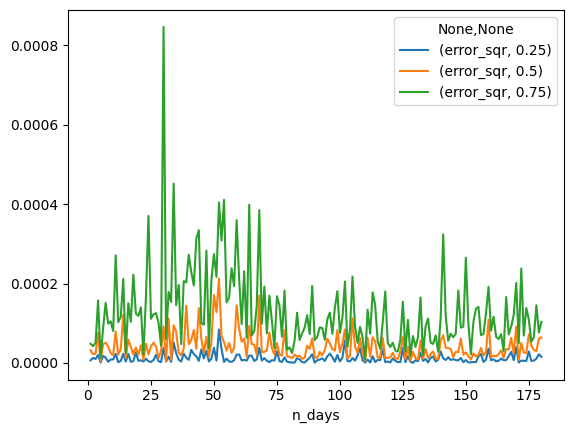

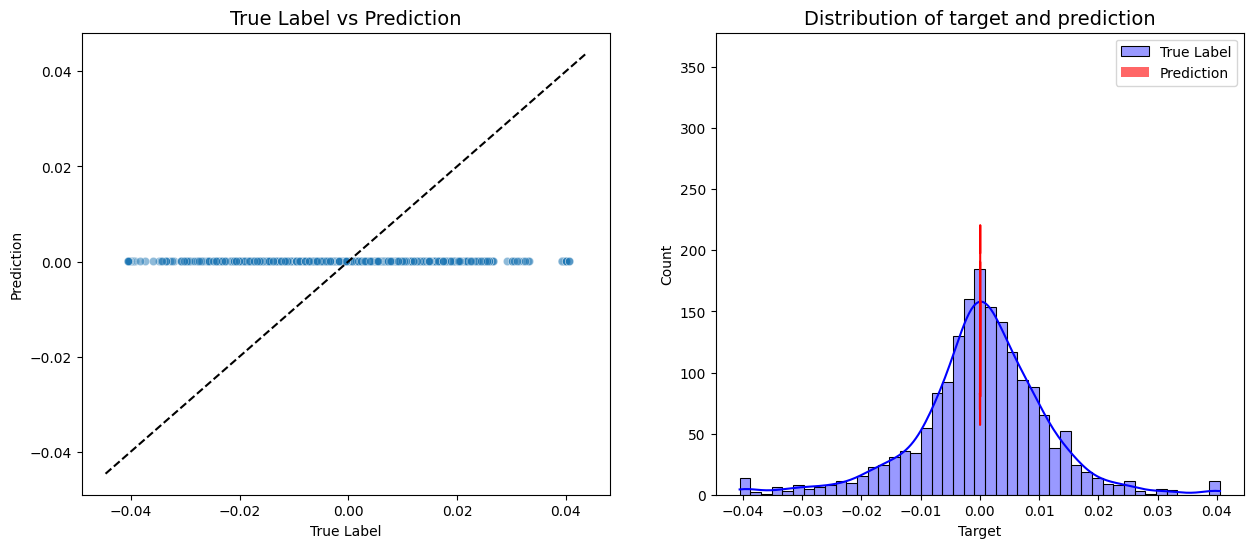

In [15]:
model = ElasticNet(alpha=13, l1_ratio=0.35, random_state=325)

processing = Pipeline([("imputer", tml.DfImputer(strategy="constant", fill_value=0)), ("scaler", tml.DfScaler())])

pipe = Pipeline([("processing", processing),
                ("model", model)])

fit_params = {"sample_weight": "date_id"}

train = create_features(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=df[TARGET], cv=ts_folds, estimator=pipe)
oof, res = cvscore.score()

summary_evaluation(res["folds_eval"], df, factor=1)

# RandomForest

In [8]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", 0.8]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
        "create_features": trial.suggest_categorical("create_features", [True, False]),
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "conversion": trial.suggest_int("conversion", 1, 10000)
    }
    processing = Pipeline([("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                           ("scaler", tml.DfScaler())])
    if param["create_features"]:
        train = create_features(data)
    else:
        train = data

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = RandomForestRegressor(max_depth=20, random_state=34, n_jobs=-1, n_estimators=100,
                                          max_features=param["max_features"], min_samples_leaf=param["min_samples_leaf"])

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id"}
    else:
        fit_params = {}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"] * param["conversion"] + 1, 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [9]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2025-11-29 22:51:17,025] A new study created in memory with name: no-name-4a4bf126-218f-4227-ad33-dc26110ebf00
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `is

Number of finished trials: 200
Best trial: {'max_features': None, 'min_samples_leaf': 94, 'create_features': True, 'strategy': 'mean', 'sample_weight': True, 'conversion': 21}


In [10]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_conversion,params_create_features,params_max_features,params_min_samples_leaf,params_sample_weight,params_strategy,state
104,104,0.641475,2025-11-29 23:30:15.774182,2025-11-29 23:38:25.330520,0 days 00:08:09.556338,21,True,None,94,True,mean,COMPLETE
153,153,0.640765,2025-11-29 23:50:08.913730,2025-11-29 23:54:41.796966,0 days 00:04:32.883236,14,True,None,98,True,mean,COMPLETE
97,97,0.640537,2025-11-29 23:27:01.448871,2025-11-29 23:35:20.317548,0 days 00:08:18.868677,5,True,None,85,True,mean,COMPLETE
90,90,0.640453,2025-11-29 23:21:46.192826,2025-11-29 23:30:15.701306,0 days 00:08:29.508480,8,True,None,85,True,mean,COMPLETE
110,110,0.640424,2025-11-29 23:31:25.066182,2025-11-29 23:41:21.937230,0 days 00:09:56.871048,5,True,None,42,True,mean,COMPLETE
89,89,0.640305,2025-11-29 23:21:44.492942,2025-11-29 23:30:23.164068,0 days 00:08:38.671126,12,True,None,85,True,mean,COMPLETE
145,145,0.640251,2025-11-29 23:49:35.672044,2025-11-29 23:54:07.051777,0 days 00:04:31.379733,3,True,None,36,True,mean,COMPLETE
93,93,0.639716,2025-11-29 23:22:15.387075,2025-11-29 23:31:20.766302,0 days 00:09:05.379227,6,True,None,52,True,mean,COMPLETE
92,92,0.639713,2025-11-29 23:22:13.430370,2025-11-29 23:31:14.648122,0 days 00:09:01.217752,5,True,None,54,True,mean,COMPLETE
159,159,0.639688,2025-11-29 23:52:18.627397,2025-11-29 23:55:09.428134,0 days 00:02:50.800737,3,True,sqrt,98,True,mean,COMPLETE


In [11]:
optuna.visualization.plot_optimization_history(study)

In [12]:
optuna.visualization.plot_param_importances(study)

Mean Squared Error: 0.00011
R2: -0.02871611560400633
MAE: 0.0076080387444827716
               min      mean       max
fold                                  
0     1.998479e-09  0.000081  0.001302
1     3.006268e-10  0.000104  0.001140
2     9.894017e-12  0.000260  0.002422
3     8.471496e-11  0.000081  0.000568
4     8.586810e-09  0.000054  0.000414
5     1.338825e-12  0.000069  0.000915
6     2.007222e-09  0.000118  0.001971


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


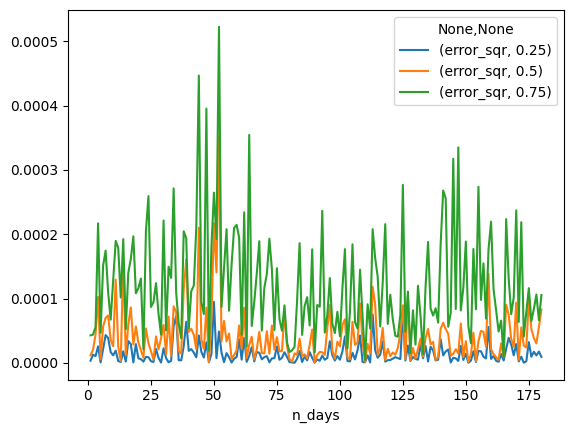

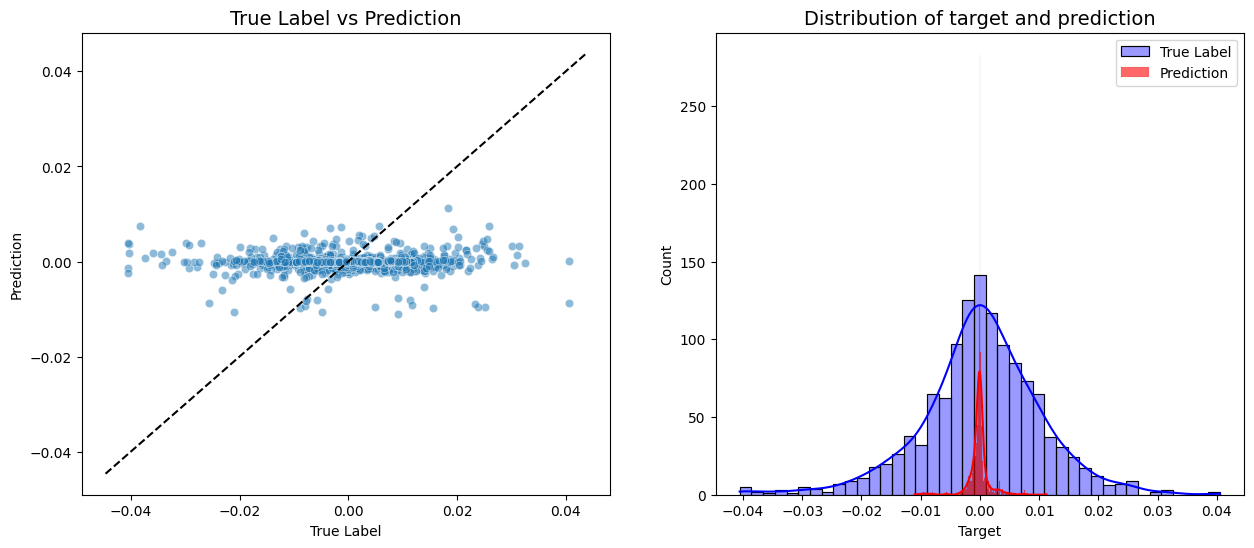

0.015146557617391894

In [ ]:
model = RandomForestRegressor(max_depth=20, random_state=34, n_jobs=-1,)

pipe = Pipeline([("processing", processing),
                ("model", model)])

cvscore = TSCrossValidate(data=train[FEATURES], target=df[TARGET], cv=ts_folds, estimator=pipe)
oof, res = cvscore.score()

summary_evaluation(res["folds_eval"])

# Xgboost

In [23]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "create_features": trial.suggest_categorical("create_features", [True, False]),
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "conversion": trial.suggest_int("conversion", 1, 10000),
        "max_depth": trial.suggest_int("max_depth", 3, 300),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 100.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 100.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3 , 300),
    }
    processing = Pipeline([("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                           ("scaler", tml.DfScaler())])
    if param["create_features"]:
        train = create_features(data)
    else:
        train = data

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = xgb.XGBRegressor(random_state=34, n_jobs=-1, early_stopping_rounds=100,
                             n_estimators=10000,
                             subsample=param["subsample"],
                             colsample_bytree=param["colsample_bytree"],
                             reg_alpha=param["reg_alpha"],
                             reg_lambda=param["reg_lambda"],
                             max_depth=param["max_depth"],
                             colsample_bylevel=param["colsample_bylevel"],
                             eval_metric="rmse")

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id", 'verbose': False,}
    else:
        fit_params = {'verbose': False,}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params, early_stopping=True)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"] * param["conversion"] + 1, 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [24]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 200
Best trial: {'create_features': True, 'strategy': 'constant', 'sample_weight': True, 'conversion': 451, 'max_depth': 278, 'reg_lambda': 71.36502694131478, 'reg_alpha': 51.30828460141355, 'colsample_bytree': 0.38849138179497006, 'colsample_bylevel': 0.5569514004685808, 'subsample': 0.42719238979635765, 'min_child_weight': 153.62749677023012}


In [25]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bylevel,params_colsample_bytree,params_conversion,params_create_features,params_max_depth,params_min_child_weight,params_reg_alpha,params_reg_lambda,params_sample_weight,params_strategy,params_subsample,state
86,86,1.082936,2025-11-29 21:21:51.329376,2025-11-29 21:27:59.419449,0 days 00:06:08.090073,0.556951,0.388491,451,True,278,153.627497,51.308285,71.365027,True,constant,0.427192,COMPLETE
99,99,0.985897,2025-11-29 21:24:30.648595,2025-11-29 21:31:02.608128,0 days 00:06:31.959533,0.536719,0.337783,194,True,84,155.865371,96.116405,60.160255,True,median,0.491870,COMPLETE
54,54,0.978025,2025-11-29 21:09:11.153086,2025-11-29 21:16:46.812767,0 days 00:07:35.659681,0.641522,0.568911,8342,False,94,3.277226,17.704130,22.444801,True,mean,0.649406,COMPLETE
68,68,0.972671,2025-11-29 21:16:14.757334,2025-11-29 21:21:51.324958,0 days 00:05:36.567624,0.617817,0.355520,1832,True,278,104.129640,85.279292,34.665455,True,median,0.481145,COMPLETE
129,129,0.910498,2025-11-29 21:41:26.208468,2025-11-29 21:53:07.048697,0 days 00:11:40.840229,0.999865,0.368726,726,True,131,142.089508,52.893669,50.653570,True,constant,0.459146,COMPLETE
184,184,0.876490,2025-11-29 22:17:12.541764,2025-11-29 22:26:13.610265,0 days 00:09:01.068501,0.857762,0.519539,334,False,130,40.957694,65.937466,64.693312,True,median,0.464918,COMPLETE
180,180,0.867990,2025-11-29 22:15:13.369698,2025-11-29 22:24:13.000858,0 days 00:08:59.631160,0.851884,0.523287,356,False,96,121.909779,65.820242,64.965317,True,median,0.467090,COMPLETE
108,108,0.825606,2025-11-29 21:29:05.344643,2025-11-29 21:38:10.457609,0 days 00:09:05.112966,0.528198,0.423523,103,True,264,127.405949,61.737263,60.409883,True,constant,0.445811,COMPLETE
127,127,0.821440,2025-11-29 21:40:34.313598,2025-11-29 21:51:05.743724,0 days 00:10:31.430126,0.458499,0.368903,742,True,129,142.508365,52.907948,49.690241,True,constant,0.458533,COMPLETE
181,181,0.819495,2025-11-29 22:16:19.632915,2025-11-29 22:24:59.814200,0 days 00:08:40.181285,0.625806,0.566323,267,False,131,154.741903,65.599840,56.816668,True,median,0.468850,COMPLETE


In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_param_importances(study)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Mean Squared Error: 0.00013
R2: -0.01570032185030734
MAE: 0.007996957805064176
               min      mean       max
fold                                  
0     5.063020e-10  0.000112  0.001543
1     1.000290e-09  0.000064  0.000877
2     6.476108e-10  0.000320  0.002578
3     5.648682e-10  0.000087  0.000886
4     8.800618e-10  0.000100  0.000704
5     2.257643e-09  0.000252  0.001972
6     6.467488e-09  0.000082  0.000703
7     4.267674e-12  0.000059  0.000470
8     2.418038e-12  0.000070  0.000923
9     5.042882e-10  0.000113  0.001440
Sharpe: 1.0789792583801552
0 0.9901211820724808
1 2.024676820262043
2 1.1555451718105945
3 2.277209713152621
4 1.6350648616129015
5 -0.2845068545464172
6 0.9630206006775136
7 0.7658315199929084
8 1.7381090743444636
9 2.683371173420827


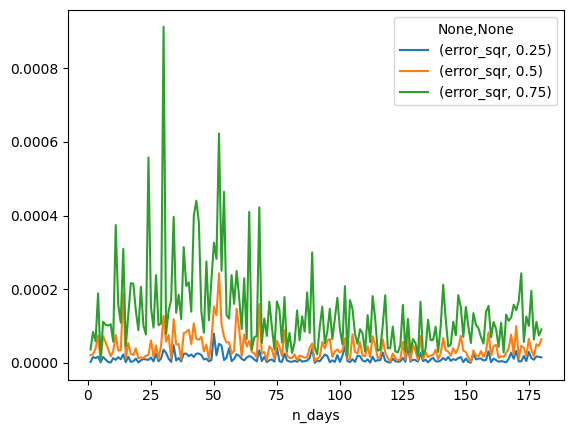

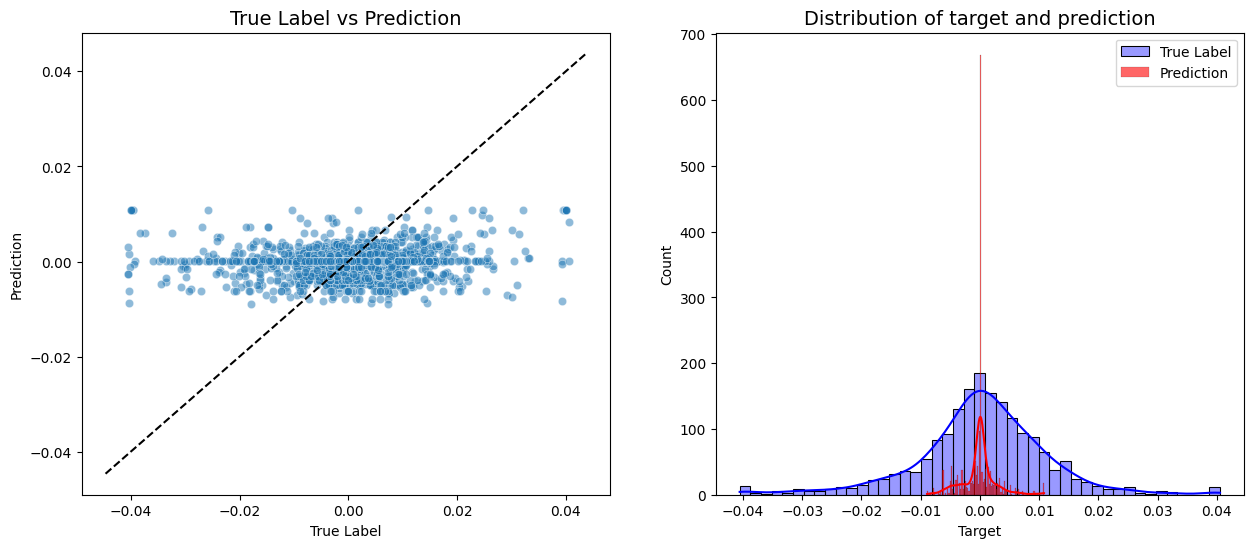

In [33]:
processing = Pipeline([("imputer", tml.DfImputer(strategy="constant", fill_value=0)),
                       ("scaler", tml.DfScaler())])

model = xgb.XGBRegressor(random_state=34, n_jobs=-1,
                         early_stopping_rounds=100,
                         n_estimators=10000,
                         colsample_bylevel=0.556,
                         colsample_bytree=0.388,
                         max_depth=278,
                         min_child_weight=153.627,
                         reg_alpha=51.3,
                         reg_lambda=71.3,
                         subsample=0.427,
                         eval_metric="rmse")

fit_params_xgb = {'verbose': False, "sample_weight": "date_id"}

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = create_features(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=df[TARGET], cv=ts_folds,
                        estimator=pipe,
                        early_stopping=True, fit_params=fit_params_xgb
                        )
oof, res = cvscore.score()

print(res["iterations"])

summary_evaluation(res["folds_eval"], orig_df=df, factor=451)

# Light GBM

In [17]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "create_features": trial.suggest_categorical("create_features", [True, False]),
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "conversion": trial.suggest_int("conversion", 1, 10000),
        "max_depth": trial.suggest_int("max_depth", 3, 300),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 100.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 100.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3 , 300),
    }
    processing = Pipeline([("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                           ("scaler", tml.DfScaler())])
    if param["create_features"]:
        train = create_features(data)
    else:
        train = data

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                             colsample_bytree=param["colsample_bytree"],
                             min_child_weight=param['min_child_weight'],
                             reg_lambda=param['reg_lambda'],
                             reg_alpha=param['reg_alpha'],
                             subsample=param['subsample'],
                             num_leaves=param["num_leaves"],
                             max_depth=param['max_depth'],
                             eval_metric="rmse")

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    callbacks = [lgb.early_stopping(100, verbose=0)]
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id", "callbacks":callbacks, "eval_metric": "rmse"}
    else:
        fit_params = {"callbacks":callbacks, "eval_metric": "rmse"}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params, early_stopping=True)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"] * param["conversion"] + 1, 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [18]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 200
Best trial: {'create_features': False, 'strategy': 'median', 'sample_weight': True, 'conversion': 3078, 'max_depth': 257, 'num_leaves': 153, 'reg_lambda': 37.29750479082837, 'reg_alpha': 7.716454114477571, 'colsample_bytree': 0.9589650641169046, 'subsample': 0.8346586895885101, 'min_child_weight': 120.94771094018284}


In [19]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_conversion,params_create_features,params_max_depth,params_min_child_weight,params_num_leaves,params_reg_alpha,params_reg_lambda,params_sample_weight,params_strategy,params_subsample,state
108,108,1.136248,2025-11-29 20:22:46.359170,2025-11-29 20:27:27.521603,0 days 00:04:41.162433,0.958965,3078,False,257,120.947711,153,7.716454,37.297505,True,median,0.834659,COMPLETE
174,174,1.109096,2025-11-29 20:35:32.735879,2025-11-29 20:39:34.676331,0 days 00:04:01.940452,0.986136,769,False,271,133.544218,142,6.672736,65.885530,True,median,0.817860,COMPLETE
190,190,1.101802,2025-11-29 20:39:33.569388,2025-11-29 20:43:01.660039,0 days 00:03:28.090651,0.999883,943,False,241,147.904672,130,30.437767,18.751275,True,median,0.837971,COMPLETE
193,193,1.100976,2025-11-29 20:39:55.773541,2025-11-29 20:43:26.496176,0 days 00:03:30.722635,0.998504,963,False,273,136.234492,130,30.497266,11.587031,True,median,0.836972,COMPLETE
180,180,1.088771,2025-11-29 20:36:17.507207,2025-11-29 20:40:31.318197,0 days 00:04:13.810990,0.949291,824,False,259,84.625173,142,6.894222,99.243328,True,median,0.840499,COMPLETE
177,177,1.074409,2025-11-29 20:35:44.116930,2025-11-29 20:39:55.772878,0 days 00:04:11.655948,0.990172,780,False,250,135.704503,142,6.453380,99.957806,True,median,0.839596,COMPLETE
109,109,1.063038,2025-11-29 20:22:46.769814,2025-11-29 20:25:21.988336,0 days 00:02:35.218522,0.957706,3328,False,255,135.552190,83,9.609426,23.739597,True,median,0.821400,COMPLETE
112,112,1.051082,2025-11-29 20:22:53.732254,2025-11-29 20:24:05.510444,0 days 00:01:11.778190,0.962527,3349,False,252,121.645873,33,11.667243,37.658880,True,median,0.972378,COMPLETE
188,188,1.042715,2025-11-29 20:37:47.938899,2025-11-29 20:41:33.853491,0 days 00:03:45.914592,0.994084,889,False,240,136.627058,131,38.548326,99.328917,True,median,0.836752,COMPLETE
191,191,1.027774,2025-11-29 20:39:34.677131,2025-11-29 20:43:08.685068,0 days 00:03:34.007937,0.995491,1007,False,256,141.806174,131,6.951272,99.576380,True,median,0.838718,COMPLETE


In [20]:
optuna.visualization.plot_optimization_history(study)

In [21]:
optuna.visualization.plot_param_importances(study)

[1, 2, 4, 1, 3, 2, 2, 1, 1, 2]
Mean Squared Error: 0.00012
R2: 0.013276149014938898
MAE: 0.007909231368312225
               min      mean       max
fold                                  
0     3.180168e-10  0.000111  0.001401
1     4.250307e-09  0.000058  0.000868
2     4.974762e-08  0.000313  0.001786
3     3.236690e-09  0.000079  0.001258
4     1.190973e-09  0.000102  0.000950
5     6.987276e-09  0.000240  0.001604
6     5.595910e-10  0.000079  0.000625
7     3.486874e-14  0.000055  0.000404
8     1.041784e-11  0.000069  0.000939
9     5.985657e-09  0.000117  0.001753
Sharpe: 0.9953804659363695
0 -0.23965565606995282
1 2.9033835812372275
2 1.5741269659763375
3 1.7460758194770964
4 0.34699079922287596
5 0.9398155051772127
6 1.587070317630274
7 1.3587905411879793
8 1.1351212263722994
9 0.5210162205164378


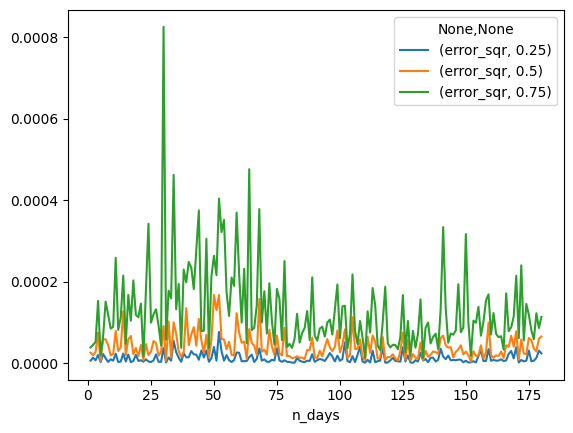

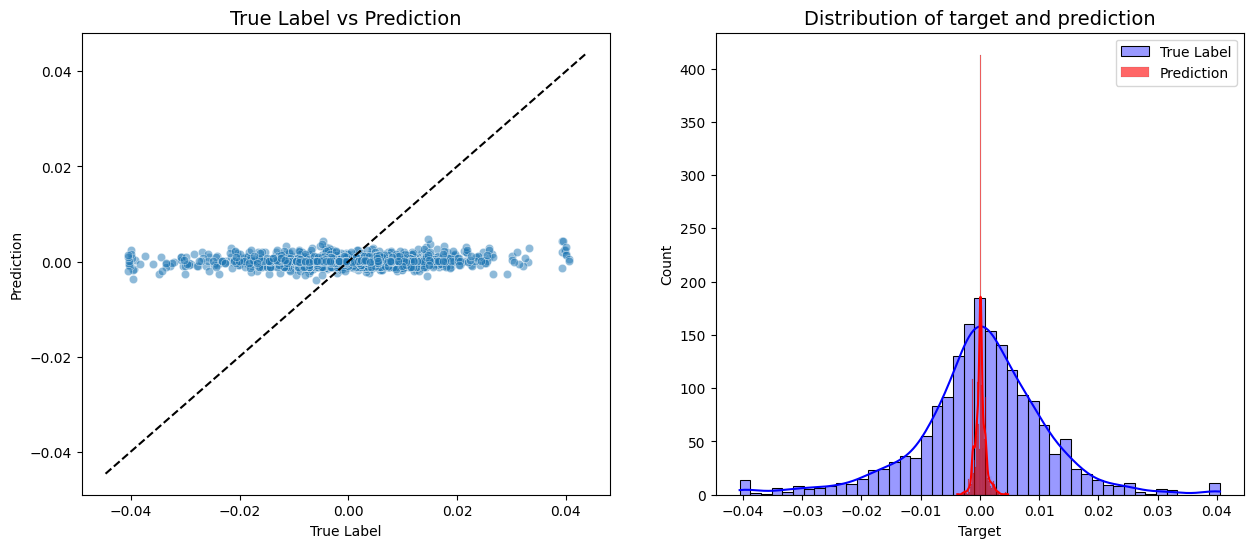

In [31]:
LGBM_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 300,      # More trees help capture patterns
    'learning_rate': 0.05,    # Lower LR for better generalization
    'num_leaves': 31,         # Default works fine
    'max_depth': 5,           # Not too deep - prevents overfitting
    'min_child_samples': 20,  # Regularization
    'subsample': 0.8,         # Row sampling for variance reduction
    'colsample_bytree': 0.8,  # Column sampling
    'reg_alpha': 0.1,         # L1 regularization
    'reg_lambda': 0.1,        # L2 regularization
    'random_state': 34,
    'verbose': -1,
    'n_jobs': -1
}

model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          colsample_bytree=0.95,
                             min_child_weight=120,
                             reg_lambda=37.2,
                             reg_alpha=7.7,
                             subsample=0.83,
                             num_leaves=153,
                             max_depth=257)

#model = lgb.LGBMRegressor(**LGBM_PARAMS)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params_lgb = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("imputer", tml.DfImputer(strategy="median", fill_value=0)), ("scaler", tml.DfScaler())])

pipe = Pipeline([("processing", processing),
                ("model", model)])

FEATURES = [c for c in df.columns if c not in DROP]

cvscore = TSCrossValidate(data=df[FEATURES], target=df[TARGET], cv=ts_folds, estimator=pipe,
                          early_stopping=True, fit_params=fit_params_lgb
                          )
oof, res = cvscore.score()

print(res["iterations"])

summary_evaluation(res["folds_eval"], orig_df=df, factor=769)